In [1]:
!pip install -qq einops tensorflow_addons

     |████████████████████████████████| 1.1 MB 45.5 MB/s 


In [2]:
import os, io
import pandas as pd
import random

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import imageio
import ipywidgets

import tensorflow as tf
import keras
from keras import layers
from tensorflow_addons.optimizers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
from IPython.display import clear_output

!wget 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip' -O archive.zip
!unzip archive.zip
!rm archive.zip
clear_output()

In [4]:
encoder = LabelEncoder()
paths = os.listdir("UCF101")
paths = ["UCF101/"+path for path in paths]
labels = [path.split("_")[1] for path in paths]

data = pd.DataFrame(data={"path": paths, "labels": encoder.fit_transform(labels)})
data = data[data["labels"] < 10]

In [5]:
train, test = train_test_split(data, test_size=0.2, stratify=data.labels, shuffle=True, random_state=42)
test, valid = train_test_split(test, test_size=0.5, random_state=42)

In [6]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)  # scales automatically
    frame = tf.image.resize_with_pad(frame, *output_size)  # adds padding instead of stretching
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224,224), frame_step=15):
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
    def __init__(self, data, n_frames):
        self.data = data
        self.n_frames = n_frames

    def __call__(self):
        video_paths, classes = self.data.values[:, 0], self.data.values[:, 1]

        pairs = list(zip(video_paths, classes))

        for path, label in pairs:
            video_frames = frames_from_video_file(path, self.n_frames) 
            yield video_frames, label

In [7]:
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype = tf.float32), tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train, 10), output_signature = output_signature).batch(8)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(valid, 10), output_signature = output_signature).batch(8)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test, 10), output_signature = output_signature).shuffle(buffer_size=len(test)).batch(8)  # shuffle 

### Convolutional 3D model

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension. 
        """
        super().__init__()
        self.seq = keras.Sequential([  
            # Spatial decomposition
            layers.Conv3D(filters=filters, kernel_size=(1, kernel_size[1], kernel_size[2]), padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters, kernel_size=(kernel_size[0], 1, 1), padding=padding)
            ])

    def call(self, x):
        return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
    """
        Residual block of the model with convolution, layer normalization, and the
        activation function, ReLU.
    """
    def __init__(self, filters, kernel_size):
            super().__init__()
            self.seq = keras.Sequential([
                Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
                layers.LayerNormalization(),
                layers.ReLU(),
                Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
                layers.LayerNormalization()
            ])

    def call(self, x):
        return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
    """
        Project certain dimensions of the tensor as the data is passed through different 
        sized filters and downsampled. 
    """
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
                                    layers.Dense(units),
                                    layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

def add_residual_block(input, filters, kernel_size):
    """
        Add residual blocks to the model. If the last dimensions of the input data
        and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters, 
                        kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        """
        Use the einops library to resize the tensor.  
        Args:
            video: Tensor representation of the video, in the form of a set of frames.
        Return:
            A downsampled size of the video according to the new height and width it should be resized to.
        """
        # b stands for batch size, t stands for time, h stands for height, 
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(images, '(b t) h w c -> b t h w c', t = old_shape['t'])
        return videos

In [9]:
HEIGHT = WIDTH = 224

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x, name="cnn3d")

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

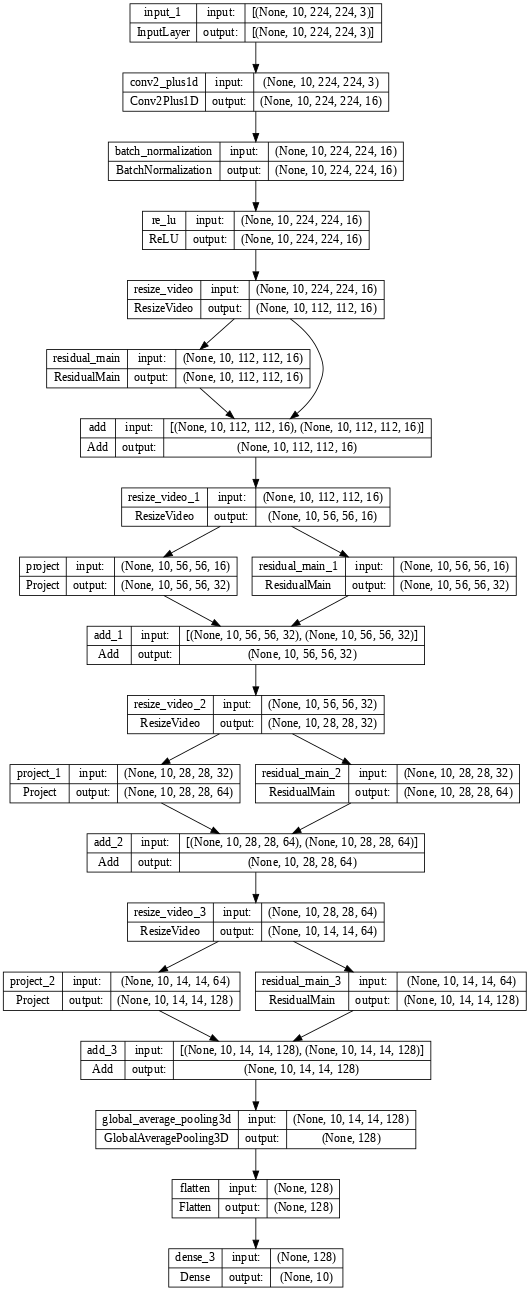

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [10]:
def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb

def test_plot(epoch=None, logs=None):
    samples = next(iter(test_ds))
    batch = tf.shape(samples[0])[0]
    ground_truths, preds, videos = [], [], []
    test_samples, labels = samples

    for i, (testsample, label) in enumerate(zip(test_samples, labels)):
        # Generate gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, (testsample.numpy() * 255).astype("uint8"), "GIF", fps=5)
            videos.append(gif.getvalue())

        # Get model prediction
        output = model.predict(tf.expand_dims(testsample, axis=0), verbose=0)[0]
        pred = np.argmax(output, axis=0)

        ground_truths.append(label.numpy().astype("int"))
        preds.append(pred)

    boxes = []
    for i in range(batch):
        ib = ipywidgets.widgets.Image(value=videos[i], width=100, height=100)

        caption = f"True: {ground_truths[i]} | Pred: {preds[i]}"

        boxes.append(make_box_for_grid(ib, caption))

    return ipywidgets.widgets.GridBox(
        boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
    )

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

callbacks = [
             # tf.keras.callbacks.LambdaCallback(on_epoch_end=test_plot),
             tf.keras.callbacks.ReduceLROnPlateau(patience=4),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(x=train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks, verbose=1)

Epoch 1/50
138/138 [==============================] - 171s 1s/step - loss: 2.1625 - accuracy: 0.2411 - val_loss: 2.3401 - val_accuracy: 0.1812 - lr: 1.0000e-04
Epoch 2/50
138/138 [==============================] - 166s 1s/step - loss: 1.8143 - accuracy: 0.3230 - val_loss: 2.2341 - val_accuracy: 0.2899 - lr: 1.0000e-04
Epoch 3/50
138/138 [==============================] - 167s 1s/step - loss: 1.6302 - accuracy: 0.3894 - val_loss: 2.0967 - val_accuracy: 0.3188 - lr: 1.0000e-04
Epoch 4/50
138/138 [==============================] - 165s 1s/step - loss: 1.4908 - accuracy: 0.4395 - val_loss: 1.6646 - val_accuracy: 0.4058 - lr: 1.0000e-04
Epoch 5/50
138/138 [==============================] - 164s 1s/step - loss: 1.3620 - accuracy: 0.5041 - val_loss: 1.2916 - val_accuracy: 0.4710 - lr: 1.0000e-04
Epoch 6/50
138/138 [==============================] - 163s 1s/step - loss: 1.2318 - accuracy: 0.5505 - val_loss: 1.1536 - val_accuracy: 0.5507 - lr: 1.0000e-04
Epoch 7/50
138/138 [====================

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_ds)

18/18 [==============================] - 16s 198ms/step - loss: 0.6092 - accuracy: 0.7518


[0.6092053055763245, 0.7518247961997986]

In [ ]:
test_plot()  # accuracy = 100%

GridBox(children=(VBox(children=(HTML(value="'True: 3 | Pred: 3'"), Box(children=(Image(value=b'GIF89a\xe0\x00…

### Transformer block

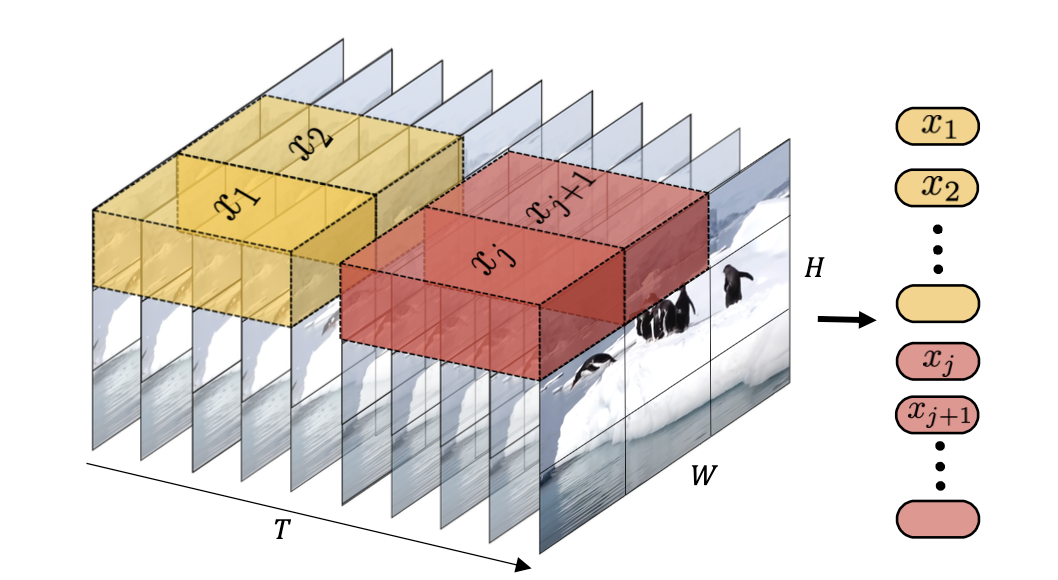

In [11]:
# DATA
INPUT_SHAPE = (10, HEIGHT, WIDTH, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (2,16,16)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 8

In [12]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        """
        First, we extract volumes from the video -- these volumes contain patches of the frame and 
        the temporal information as well. The volumes are then flattened to build video tokens.
        """
        super(TubeletEmbedding, self).__init__(**kwargs)
        self.projection = layers.Conv3D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super(PositionalEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(input_dim=num_tokens, output_dim=self.embed_dim)
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [13]:
inputs = layers.Input(shape=INPUT_SHAPE)

# Create patches.
patches = TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE)(inputs)
    
# Encode patches.
encoded_patches = PositionalEncoder(embed_dim=PROJECTION_DIM)(patches)

# Create multiple layers of the Transformer block.
for _ in range(NUM_LAYERS):
    # Layer normalization and MHSA
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS, dropout=0.1)(x1, x1)

    # Skip connection
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer Normalization and MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = keras.Sequential(
        [
            layers.Dense(units=PROJECTION_DIM * 4, activation=tf.nn.gelu),
            layers.Dense(units=PROJECTION_DIM, activation=tf.nn.gelu),
        ]
    )(x3)

    # Skip connection
    encoded_patches = layers.Add()([x3, x2])

# Layer normalization and Global average pooling.
representation = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)
representation = layers.GlobalAvgPool1D()(representation)

# Classify outputs.
outputs = layers.Dense(units=NUM_CLASSES)(representation)

# Create the Keras model.
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY), 
              metrics=['accuracy'])

callbacks = [
             # tf.keras.callbacks.LambdaCallback(on_epoch_end=test_plot),
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

In [15]:
history = model.fit(x=train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

Epoch 1/60
138/138 [==============================] - 184s 1s/step - loss: 2.4086 - accuracy: 0.1638 - val_loss: 2.2094 - val_accuracy: 0.1739 - lr: 1.0000e-04
Epoch 2/60
138/138 [==============================] - 161s 1s/step - loss: 2.1755 - accuracy: 0.1947 - val_loss: 2.1314 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/60
138/138 [==============================] - 159s 1s/step - loss: 2.0144 - accuracy: 0.2630 - val_loss: 2.0602 - val_accuracy: 0.2174 - lr: 1.0000e-04
Epoch 4/60
138/138 [==============================] - 160s 1s/step - loss: 1.8602 - accuracy: 0.3085 - val_loss: 1.8877 - val_accuracy: 0.3261 - lr: 1.0000e-04
Epoch 5/60
138/138 [==============================] - 158s 1s/step - loss: 1.7313 - accuracy: 0.3694 - val_loss: 1.9925 - val_accuracy: 0.3188 - lr: 1.0000e-04
Epoch 6/60
138/138 [==============================] - 161s 1s/step - loss: 1.6347 - accuracy: 0.4067 - val_loss: 2.0079 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 7/60
138/138 [====================

KeyboardInterrupt: ignored

In [17]:
test_plot()

GridBox(children=(VBox(children=(HTML(value="'True: 8 | Pred: 8'"), Box(children=(Image(value=b'GIF89a\xe0\x00…

In [18]:
from itertools import product
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<Figure size 360x360 with 0 Axes>

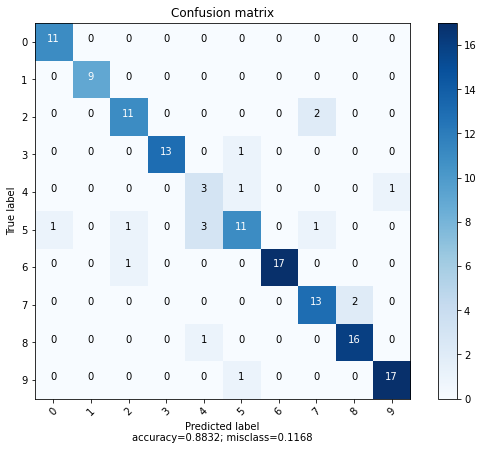

In [22]:
y_true = test.labels.values
test_ds_unshuffle = tf.data.Dataset.from_generator(FrameGenerator(test, 10), output_signature = output_signature).batch(1)

y_pred = model.predict(test_ds_unshuffle, verbose=0).argmax(1)

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, target_names=[i for i in range(10)], normalize=False, title='Confusion matrix',)
plt.show()